In [31]:
import matplotlib.pyplot as plt
from IPython.display import display, Math
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# %matplotlib nbagg
from skimage import data,filters
import scipy.ndimage as ndimage
import numpy as np
from PIL import Image
from math import floor, ceil
import cv2
import os
import math
import random
import pandas as pd

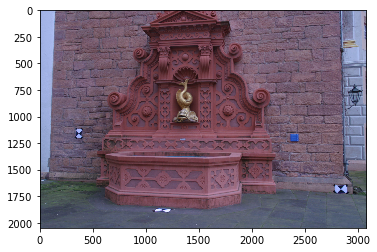

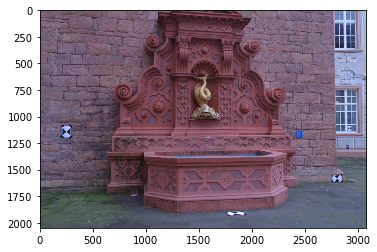

In [7]:
def image1():
    return plt.imread("CVassignment4_files/fountain1.jpg")
def image2():
    return plt.imread("CVassignment4_files/fountain2.jpg")
def image1_grey():
    gray = cv2.cvtColor(image1(), cv2.COLOR_BGR2GRAY)
    return np.dstack([gray, gray, gray])
def k1():
    k = pd.read_csv("CVassignment4_files/K1.txt", sep="\s+", header=None)
    k = np.asarray(k)
    return k
def k2():
    k = pd.read_csv("CVassignment4_files/K2.txt", sep="\s+", header=None)
    k = np.asarray(k)
    return k
def matches():
    matches = pd.read_csv("CVassignment4_files/matches.txt", sep="\s+", header=None)
    matches = np.asarray(matches, dtype=int)
    return matches
colour = (0,200,10)
start_col = (0,0,255)
end_col = (255,0,0)
thresh = 200

plt.imshow(image1())
plt.show()
plt.imshow(image2())
plt.show()


# Question 1
## 1a

In [8]:
def draw_matches(image, matches):
    for m in matches:
        cv2.circle(image,(m[0],m[1]), 50, start_col, thickness=1, lineType=8, shift=0)
        cv2.circle(image,(m[2],m[3]), 50, end_col, thickness=1, lineType=8, shift=0)
        cv2.line(image, (m[0],m[1]), (m[2],m[3]), colour, thickness=10, lineType=8)
    plt.imshow(image,cmap='gray')
    plt.show()

def get_good_matches(matches, threshold):
    end_points = matches[:, 2:4]
    start_points = matches[:, 0:2]
    good_matches = []
    for i in range(len(matches)):
        start = start_points[i]
        end = end_points[i]
        distance = math.sqrt((start[0]-end[0])**2 + (start[1]-end[1])**2)
        if distance < threshold:
            good_matches.append(matches[i])
    return np.asarray(good_matches)

def get_F(matches):
    X = matches[:, 2:4]
    x = matches[:, :2]
    
    A = []
    for i in range(0, len(x)):
        x1 = x[i][0] 
        y1 = x[i][1]
        X1 = X[i][0]
        Y1 = X[i][1]
        A.append([x1*X1, y1*X1, X1, x1*Y1,y1*Y1, Y1, x1, y1, 1])
        
    _,_,V = np.linalg.svd(A)
    f =V.T[:,V.shape[1] - 1]
    F_1 = np.array([
        [f[0],f[1],f[2]],
        [f[3],f[4],f[5]],
        [f[6],f[7],f[8]],
    ])
    U, S, V = np.linalg.svd(F_1)
    F = U.dot(np.diag(S).dot(V))
    return F

def get_F_RANSAC(matches):
    F = np.array([])
    inliers =[]
    for i in range(0, 1000000):
        r1 = random.randrange(0, len(matches), 1)
        r2 = random.randrange(0, len(matches), 1)
        r3 = random.randrange(0, len(matches), 1)
        r4 = random.randrange(0, len(matches), 1)
        r5 = random.randrange(0, len(matches), 1)
        r6 = random.randrange(0, len(matches), 1)
        r7 = random.randrange(0, len(matches), 1)
        r8 = random.randrange(0, len(matches), 1)
        ran_matches = np.array([
            matches[r1],
            matches[r2],
            matches[r3],
            matches[r4],
            matches[r5],
            matches[r6],
            matches[r7],
            matches[r8],
        ])
        temp_F = get_F(ran_matches)
        temp_inliers = []
        for match in matches:
            X = match[2:4]
            X = np.array([X[0], X[1], 1])
            x = match[:2] 
            x = np.array([x[0], x[1], 1])
            sd = X.dot(temp_F.dot(x))
            sd = sd**2
            sd = sd/((temp_F.dot(x)[0])**2 + (temp_F.dot(x)[1])**2 + (temp_F.T.dot(X)[0])**2 + (temp_F.T.dot(X)[1])**2)
            if sd < 10:
                temp_inliers.append(match)
        if len(temp_inliers) > len(inliers):
            inliers = temp_inliers
        inliers = np.asarray(inliers)
        return get_F(inliers), inliers

Image 1 Point is blue, Image 2 point is red
All Matches:


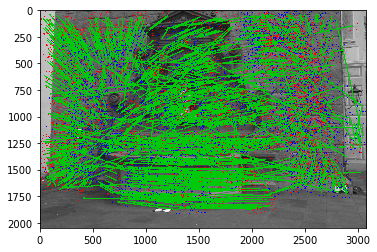

Good Matches: Threshold =  200


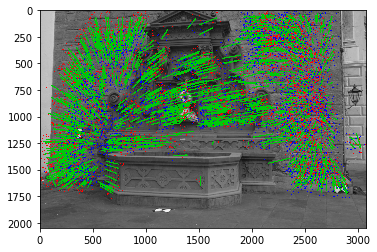

In [9]:
good_matches = get_good_matches(matches(), thresh)
print("Image 1 Point is blue, Image 2 point is red")
print("All Matches:")
draw_matches(image1_grey(), matches())
print("Good Matches: Threshold = ", thresh)
draw_matches(image1_grey(), get_good_matches(matches(), thresh))

It is better to use a leniancy threshold here, because the rest of the pipeline will be aimed at gathering inliers to exclude outliers and a high leniancy threshold will allow us to keep more inliers at the expense of a few more outliers that should be dealt with in the RANSAC phase.

## 1b

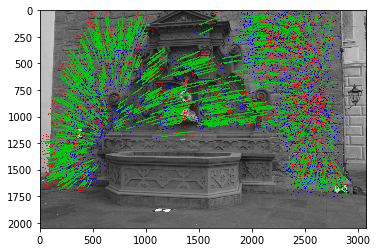

In [13]:
good_matches = get_good_matches(matches(), thresh)
F_R, RANSAC_matches = get_F_RANSAC(good_matches)
draw_matches(image1_grey(), RANSAC_matches)

## 1c

In [59]:
def get_E(K, K_1, F):
    return K_1.T.dot(F).dot(K)

def fix_SVD(svd):
    U = svd[0]
    E = svd[1]
    V = svd[2].T
    if np.linalg.det(U) > 0 and np.linalg.det(V) < 0:
        E = -E
        V= -V
    elif np.linalg.det(U) < 0 and np.linalg.det(V) > 0:
        E = -E
        U = -U

E = get_E(k1(), k2(), F_R)
svd_E = np.linalg.svd(E)
print(E)

[[ 0.03079269 -1.1759932   0.12973596]
 [-2.29163702 -0.13708935 -9.08293733]
 [-0.02243289  9.44067809 -0.10568253]]


In [55]:
print("Sigma = {}".format(svd_E[1]))

Sigma = [9.51485307e+00 9.36891285e+00 1.35849341e-03]


In [58]:
np.linalg.det(E)

-0.12110130458506731